## ANALISIS DENUNCIAS POR VIOLENCIA DE GÉNERO EN ESPAÑA

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pylab as plt
import seaborn as sns
import sys
sys.path.append('../src')
from suport import plot_denuncias
from suport import trimestre
from suport import norm_data
from suport import plot_four_lines
from suport import plot_llamadas
from suport import plot_delitos
import plotly.express as px
import plotly.graph_objects as go


In [2]:
fest  = pd.read_csv('../data_clean/scrapeo/festivos_provincia.csv')
norm = pd.read_csv('../data_clean/scrapeo/normativas.csv')
denu = pd.read_csv('../data_clean/portal_estadistico_vio_gen/denuncias.csv')
llam = pd.read_csv('../data_clean/portal_estadistico_vio_gen/llamadas016.csv')
ord = pd.read_csv('../data_clean/portal_estadistico_vio_gen/ordenes_prot.csv')
disp = pd.read_csv('../data_clean/portal_estadistico_vio_gen/dispositivos.csv')
men = pd.read_csv('../data_clean/portal_estadistico_vio_gen/menores.csv')
vic = pd.read_csv('../data_clean/portal_estadistico_vio_gen/victimas_mortales.csv')
sent = pd.read_csv('../data_clean/ine/sentencias.csv')
tipos = pd.read_csv('../data_clean/ine/tipos_violencias.csv')
cond = pd.read_csv('../data_clean/ine/condenados_edad.csv')
salud = pd.read_csv('../data_clean/ine/salud_mental.csv')
paro = pd.read_csv('../data_clean/ine/tasa_actividad.csv')
alcohol = pd.read_csv('../data_clean/ine/alcohol.csv')
educ = pd.read_csv('../data_clean/ine/nivel_educativo.csv')
total_prov = pd.read_csv('../data_clean/ine/total_prov.csv')
total_ccaa = pd.read_csv('../data_clean/ine/total_ccaa.csv')

In [3]:
denu.describe(include='object').T

,count,unique,top,freq
trimestre,21112,4,primero,5460
origen_denuncia,21112,7,victima,3016
provincia,21112,51,cuenca,812
comunidad,21112,18,castilla y leon,3654


In [4]:
denu.describe()

,año,total_denuncias
count,21112.000000,21112.000000
mean,2015.758621,101.750616
std,4.190854,305.210568
min,2009.000000,0.000000
25%,2012.000000,1.000000
50%,2016.000000,9.000000
75%,2019.000000,67.000000
max,2023.000000,5392.000000


In [5]:
mujeres_prov = total_prov[total_prov['sexo'] == 'mujeres']
mujeres_prov = mujeres_prov.sort_values(by=['año', 'provincia'])
mujeres_prov  # Población total de mujeres por año y provincia

,provincia,sexo,año,total
47,alava,mujeres,2007,153419
102,albacete,mujeres,2007,195338
103,alicante,mujeres,2007,911809
101,almeria,mujeres,2007,313406
26,asturias,mujeres,2007,559570
...,...,...,...,...
1496,valencia,mujeres,2021,1321351
1507,valladolid,mujeres,2021,266518
1530,vizcaya,mujeres,2021,596918
1552,zamora,mujeres,2021,85174


In [6]:
denu.head()

,año,trimestre,origen_denuncia,provincia,comunidad,total_denuncias
0,2009,primero,victima,almeria,andalucia,40
1,2009,primero,familiar,almeria,andalucia,1
2,2009,primero,policia_victima,almeria,andalucia,419
3,2009,primero,policia_familiar,almeria,andalucia,7
4,2009,primero,intervencion_policial_directa,almeria,andalucia,82


COMBINACION DENUNCIAS POR VG CON POBLACION TOTAL DE MUJERES

In [7]:
denu_filtrado = denu.groupby(['año', 'provincia'], as_index=False)['total_denuncias'].sum()
denu_filtrado.head()

,año,provincia,total_denuncias
0,2009,alava,740
1,2009,albacete,959
2,2009,alicante,7757
3,2009,almeria,2604
4,2009,asturias,2373


In [8]:
# Primero vamos a unir los df de denuncias y de poblacion total de mujeres:
denu_combi = pd.merge(denu_filtrado, mujeres_prov, on=['año', 'provincia'], how='left')

# Ahora vamos a obtener la tasa de denuncias por cada 1000 mujeres:
denu_combi['tasa_por_1000'] = denu_combi['total_denuncias'] / denu_combi['total'] * 1000

# Ahora filtramos para que coincidan los años y las provincias:
denu_combi = denu_combi[denu_combi['año'] >= 2009][['año', 'provincia', 'total_denuncias', 'tasa_por_1000']]

# Por último obtenemos la tasa de denuncias por mujeres (1 de cada x mujeres denunció por violencia de género):
denu_combi['mujeres_por_denuncia'] = 1 / (denu_combi['tasa_por_1000'] / 1000)

In [9]:
denu_combi

,año,provincia,total_denuncias,tasa_por_1000,mujeres_por_denuncia
0,2009,alava,740,4.701368,212.704054
1,2009,albacete,959,4.801506,208.267987
2,2009,alicante,7757,8.090220,123.606033
3,2009,almeria,2604,7.842641,127.508065
4,2009,asturias,2373,4.204666,237.831016
...,...,...,...,...,...
773,2023,valencia,6794,NaN,NaN
774,2023,valladolid,618,NaN,NaN
775,2023,vizcaya,1817,NaN,NaN
776,2023,zamora,197,NaN,NaN


In [10]:
denu_combi.describe().T

,count,mean,std,min,25%,50%,75%,max
año,778.0,2015.983290,4.316140,2009.000000,2012.000000,2016.000000,2020.000000,2023.000000
total_denuncias,778.0,2773.167095,3876.682796,94.000000,690.250000,1501.000000,3089.750000,27798.000000
tasa_por_1000,676.0,5.640718,2.653591,1.632034,3.875873,5.048318,6.908502,23.898933
mujeres_por_denuncia,676.0,210.665106,86.479588,41.842872,144.749641,198.085773,258.006567,612.732394


In [11]:
denu_combi.sort_values(by='mujeres_por_denuncia')  # Se observa que Cuenca es la ciudad con mayor tasa de denuncias por violencia de género durante varios años

,año,provincia,total_denuncias,tasa_por_1000,mujeres_por_denuncia
120,2011,cuenca,961,23.898933,41.842872
173,2012,cuenca,833,20.282445,49.303721
537,2019,cuenca,848,20.255583,49.369104
17,2009,cuenca,739,19.166926,52.173207
433,2017,cuenca,796,18.986285,52.669598
...,...,...,...,...,...
773,2023,valencia,6794,NaN,NaN
774,2023,valladolid,618,NaN,NaN
775,2023,vizcaya,1817,NaN,NaN
776,2023,zamora,197,NaN,NaN


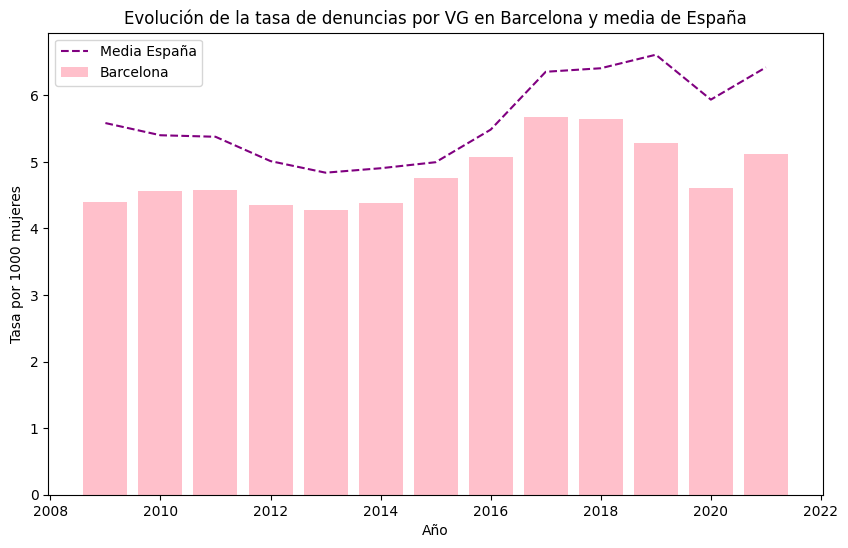

In [12]:
# Gráfico para visualizar las denuncias según provincia indicada y media española:
plot_denuncias(denu_combi, 'barcelona')

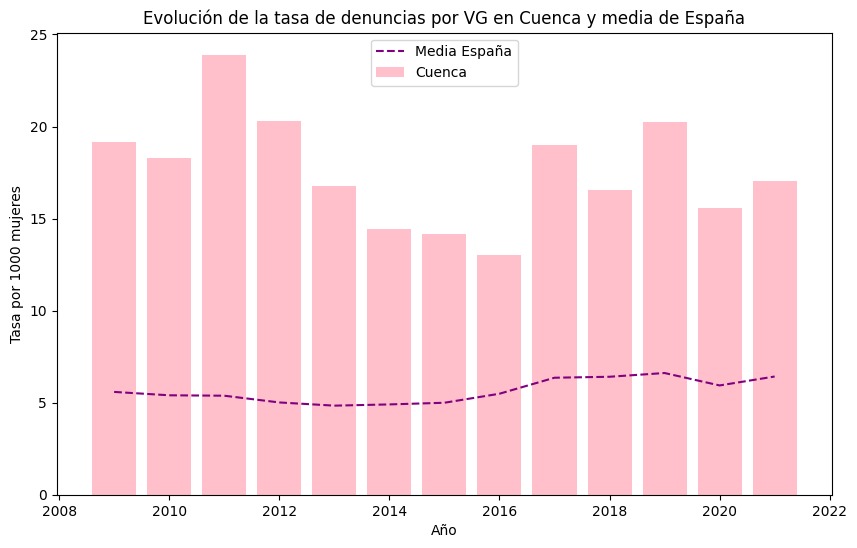

In [13]:
plot_denuncias(denu_combi, 'cuenca')

## ANALISIS LLAMADAS AL 016

In [14]:
llam.groupby('llamante')['total_llamadas'].sum()

llamante
desconocido     51605
familiar       297942
usuaria        869482
Name: total_llamadas, dtype: int64

In [15]:
llam.describe(include='object').T

,count,unique,top,freq
trimestre,12508,4,tercero,3233
llamante,12508,3,desconocido,5618
provincia,12508,51,cuenca,472
comunidad,12508,18,castilla y leon,2124


In [16]:
llam.groupby('llamante')['total_llamadas'].sum()

llamante
desconocido     51605
familiar       297942
usuaria        869482
Name: total_llamadas, dtype: int64

In [17]:
llam.groupby('trimestre')['total_llamadas'].sum()

trimestre
cuarto     291497
primero    285685
segundo    313793
tercero    328054
Name: total_llamadas, dtype: int64

In [18]:
llam.head()

,año,trimestre,llamante,provincia,comunidad,total_llamadas
0,2007,tercero,usuaria,almeria,andalucia,3
1,2007,tercero,familiar,almeria,andalucia,0
2,2007,tercero,desconocido,almeria,andalucia,0
3,2007,cuarto,usuaria,almeria,andalucia,150
4,2007,cuarto,familiar,almeria,andalucia,27


In [19]:
denu_filt = denu.groupby(['año', 'trimestre', 'provincia'], as_index=False)['total_denuncias'].sum()
llam_group = llam.groupby(['año', 'trimestre', 'provincia'], as_index=False)['total_llamadas'].sum()
llam_group = llam_group[llam_group['año'] >= 2009]
llam_denu = pd.merge(llam_group, denu_filt, on = ['año', 'trimestre', 'provincia'], how='left')
llam_denu.head()


,año,trimestre,provincia,total_llamadas,total_denuncias
0,2009,cuarto,alava,54,194.0
1,2009,cuarto,albacete,97,237.0
2,2009,cuarto,alicante,639,1813.0
3,2009,cuarto,almeria,204,545.0
4,2009,cuarto,asturias,384,505.0


In [20]:
corr = llam_denu[['total_llamadas', 'total_denuncias']].corr()
corr

,total_llamadas,total_denuncias
total_llamadas,1.000000,0.931771
total_denuncias,0.931771,1.000000


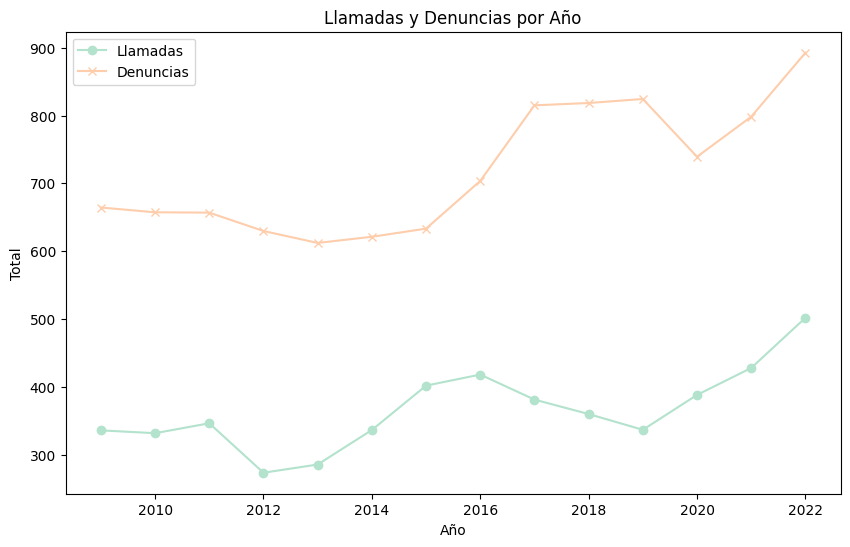

In [21]:

df_selected = llam_denu[['año', 'total_llamadas', 'total_denuncias']]
df_selected = df_selected[df_selected['año'] <= 2022]
# Agrupar por año y calcular la suma de llamadas y denuncias
df_grouped = df_selected.groupby('año').mean().reset_index()


# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Línea para llamadas
plt.plot(df_grouped['año'], df_grouped['total_llamadas'], label='Llamadas', marker='o', color=sns.color_palette('Pastel2')[0])

# Línea para denuncias
plt.plot(df_grouped['año'], df_grouped['total_denuncias'], label='Denuncias', marker='x', color=sns.color_palette('Pastel2')[1])

# Etiquetas y título
plt.xlabel('Año')
plt.ylabel('Total')
plt.title('Llamadas y Denuncias por Año')
plt.legend()
plt.grid(False)

# Mostrar el gráfico
plt.show()

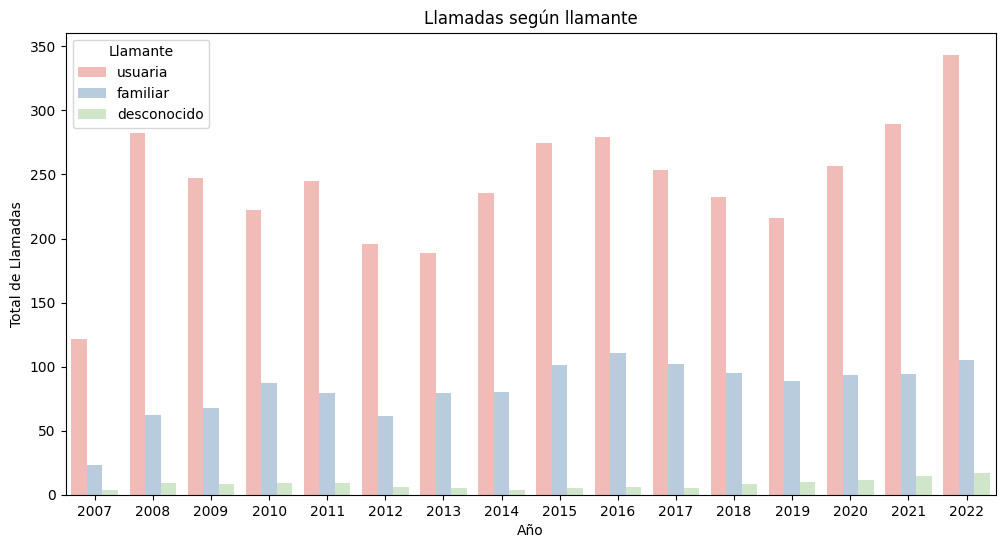

In [22]:
df_filtered = llam[llam['año'] <= 2022]

# Creamos el gráfico de barras agrupado por año y coloreado por llamante
plt.figure(figsize=(12, 6))
sns.barplot(x='año', y='total_llamadas', hue='llamante', data=df_filtered, errorbar=None, palette='Pastel1')

plt.xlabel('Año')
plt.ylabel('Total de Llamadas')
plt.title('Llamadas según llamante')
plt.legend(title='Llamante')

plt.show()

COMBINACION LLAMADAS AL 016 CON POBLACION TOTAL DE MUJERES

In [23]:
llam_filtrado = llam.groupby(['año', 'provincia'], as_index=False)['total_llamadas'].sum()

# Primero vamos a unir los df de llamadas y de poblacion total de mujeres:
llam_combi = pd.merge(llam_filtrado, mujeres_prov, on=['año', 'provincia'], how='left')

# Ahora vamos a obtener la tasa de denuncias por cada 1000 mujeres:
llam_combi['tasa_por_1000'] = llam_combi['total_llamadas'] / llam_combi['total'] * 1000

# Ahora filtramos para que coincidan los años y las provincias:
llam_combi = llam_combi[llam_combi['año'] >= 2009][['año', 'provincia', 'total_llamadas', 'tasa_por_1000']]

# Por último obtenemos la tasa de denuncias por mujeres (1 de cada x mujeres denunció por violencia de género):
llam_combi['mujeres_por_llamada'] = 1 / (llam_combi['tasa_por_1000'] / 1000)

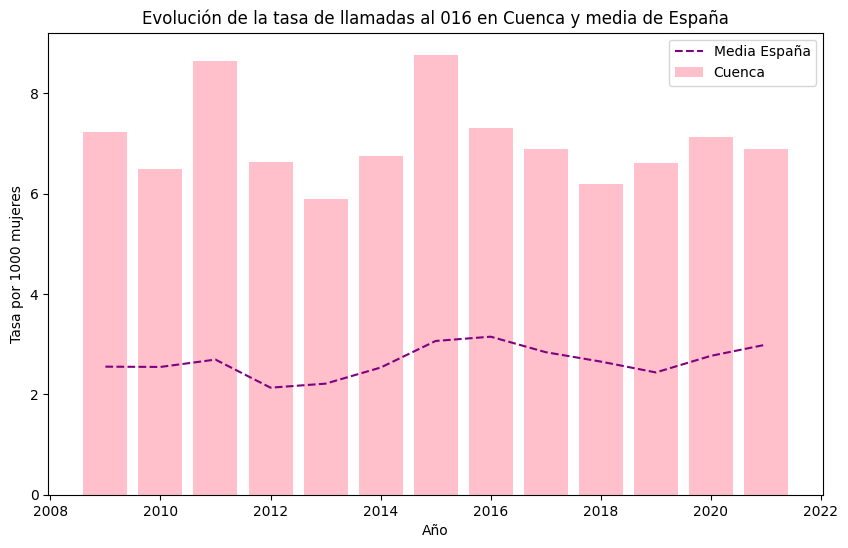

In [24]:
plot_llamadas(llam_combi, 'cuenca')

In [25]:
llam.head()

,año,trimestre,llamante,provincia,comunidad,total_llamadas
0,2007,tercero,usuaria,almeria,andalucia,3
1,2007,tercero,familiar,almeria,andalucia,0
2,2007,tercero,desconocido,almeria,andalucia,0
3,2007,cuarto,usuaria,almeria,andalucia,150
4,2007,cuarto,familiar,almeria,andalucia,27


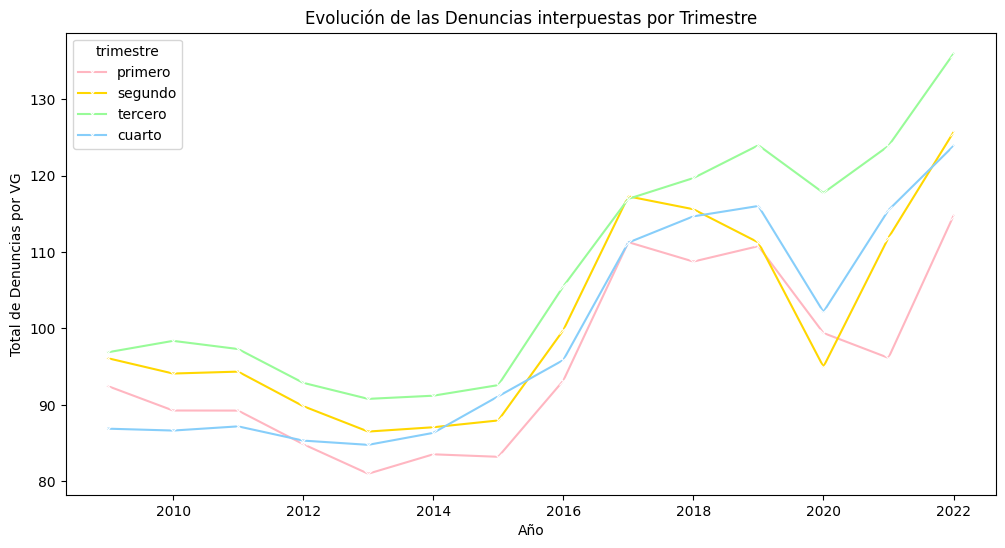

In [26]:
df_filtered = denu[(denu['año'] >= 2008) & (denu['año'] <= 2022)]

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
sns.lineplot(x='año', y='total_denuncias', hue='trimestre', palette = ['#FFB6C1', '#FFD700', '#98FB98', '#87CEFA'], data=df_filtered, marker='x', errorbar=None)

# Etiquetas y título
plt.xlabel('Año')
plt.ylabel('Total de Denuncias por VG')
plt.title('Evolución de las Denuncias interpuestas por Trimestre')

# Mostrar el gráfico
plt.show()

In [27]:
fest.head()

,provincia,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre
0,albacete,2,0,0,2,1,1,0,1,0,1,1,3
1,alicante,2,0,1,3,0,1,0,1,0,1,1,2
2,almeria,2,1,0,2,1,0,0,1,0,1,1,3
3,avila,2,0,0,3,1,0,0,1,0,1,1,3
4,badajoz,2,0,0,2,1,0,0,1,1,1,1,3


In [28]:
fest_melted = pd.melt(fest, id_vars=['provincia'], var_name='mes', value_name='total_festivos')
fest_melted.head()

,provincia,mes,total_festivos
0,albacete,enero,2
1,alicante,enero,2
2,almeria,enero,2
3,avila,enero,2
4,badajoz,enero,2


In [29]:
fest_melted.describe(include = object)

,provincia,mes
count,636,636
unique,53,12
top,albacete,enero
freq,12,53


### COMBINACION LLAMADAS, DENUNCIAS, VICTIMAS Y FESTIVOS

In [30]:
vic_filt = vic[vic['año'] >= 2009][['año', 'trimestre', 'provincia', 'total_victimas_mortales']]
vic_filt = vic_filt.groupby(['año', 'trimestre', 'provincia']).sum().reset_index()
vic_filt.head()

,año,trimestre,provincia,total_victimas_mortales
0,2009,cuarto,alava,0
1,2009,cuarto,albacete,0
2,2009,cuarto,alicante,1
3,2009,cuarto,almeria,1
4,2009,cuarto,asturias,0


In [31]:
fest_melted.head()

,provincia,mes,total_festivos
0,albacete,enero,2
1,alicante,enero,2
2,almeria,enero,2
3,avila,enero,2
4,badajoz,enero,2


In [32]:
llam_denu_vic = llam_group.merge(denu_filt, on=['año', 'trimestre', 'provincia'], how='left').merge(vic_filt, on=['año', 'trimestre', 'provincia'], how='left')

llam_denu_vic.head()

,año,trimestre,provincia,total_llamadas,total_denuncias,total_victimas_mortales
0,2009,cuarto,alava,54,194.0,0
1,2009,cuarto,albacete,97,237.0,0
2,2009,cuarto,alicante,639,1813.0,1
3,2009,cuarto,almeria,204,545.0,1
4,2009,cuarto,asturias,384,505.0,0


In [33]:
fest_melted['trimestre'] = fest_melted['mes'].apply(trimestre)
fest_melted = fest_melted.groupby(['trimestre', 'provincia'])['total_festivos'].sum().reset_index()

fest_melted.head()

,trimestre,provincia,total_festivos
0,cuarto,albacete,5
1,cuarto,alicante,4
2,cuarto,almeria,5
3,cuarto,avila,5
4,cuarto,badajoz,5


In [34]:
llam_denu_fest_vic = llam_denu_vic.merge(fest_melted, on=['trimestre', 'provincia'], how='left')
llam_denu_fest_vic = llam_denu_fest_vic[(llam_denu_fest_vic['año'] >= 2009) & (denu['año'] <= 2022)]
llam_denu_fest_vic.head()

,año,trimestre,provincia,total_llamadas,total_denuncias,total_victimas_mortales,total_festivos
0,2009,cuarto,alava,54,194.0,0,NaN
1,2009,cuarto,albacete,97,237.0,0,5.0
2,2009,cuarto,alicante,639,1813.0,1,4.0
3,2009,cuarto,almeria,204,545.0,1,5.0
4,2009,cuarto,asturias,384,505.0,0,NaN


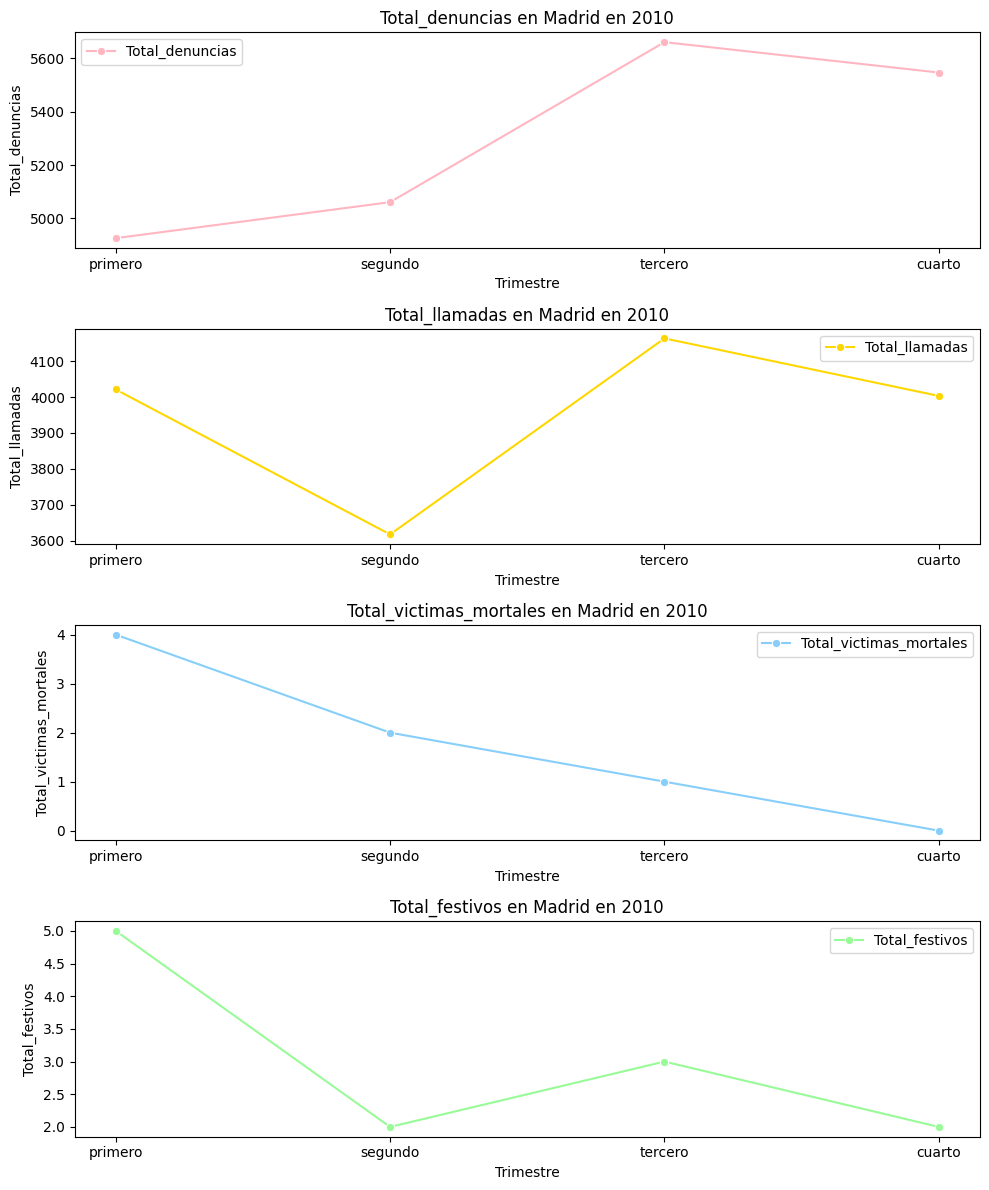

In [35]:
plot_four_lines(llam_denu_fest_vic, 'madrid', 2010)


### NORMATIVAS POR CCAA 

In [36]:
norm.head()

,Unnamed: 0,2003,2004,2005,2007,2008,2010,2011,2012,2015,2016,2017,2018,2019,2020,2021,2022
0,pais vasco,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,cataluna,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2,galicia,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0
3,andalucia,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,principado de asturias,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [37]:

norm.rename(columns={'Unnamed: 0': 'comunidad'}, inplace=True)
norm = pd.melt(norm, id_vars=['comunidad'], var_name='año', value_name='total_normativas')
norm.head()


,comunidad,año,total_normativas
0,pais vasco,2003,0
1,cataluna,2003,0
2,galicia,2003,0
3,andalucia,2003,0
4,principado de asturias,2003,0


In [38]:
denu2 = denu.groupby(['año', 'comunidad'], as_index=False)['total_denuncias'].sum()
llam2 = llam.groupby(['año','comunidad'], as_index=False)['total_llamadas'].sum()
vic2 = vic.groupby(['año', 'comunidad'], as_index=False)['total_victimas_mortales'].sum()
men2 = men.groupby(['año', 'comunidad'], as_index=False)['total_menores_vict_mortales'].sum()
datos = llam2.merge(denu2, on = ['año', 'comunidad'], how='left').merge(vic2, on = ['año', 'comunidad'], how='left').merge(men2, on = ['año', 'comunidad'], how='left')
datos = datos[datos['año'] >= 2013]
datos.head()

,año,comunidad,total_llamadas,total_denuncias,total_victimas_mortales,total_menores_vict_mortales
108,2013,andalucia,11024,26476.0,11,2.0
109,2013,aragon,1219,3074.0,2,0.0
110,2013,asturias,1296,2438.0,1,0.0
111,2013,canarias,3610,7111.0,2,1.0
112,2013,cantabria,698,1137.0,1,0.0


In [39]:
norm['año'] = norm['año'].astype(int)
norm = norm.sort_values(by = 'total_normativas')

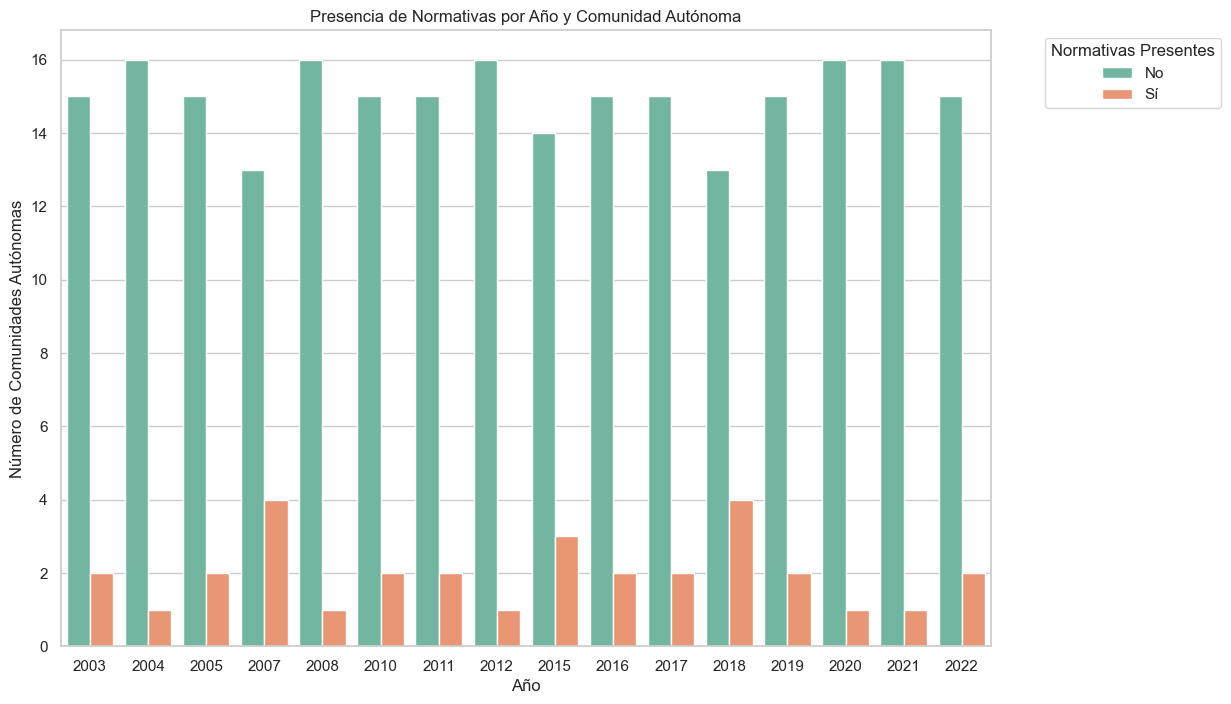

In [40]:
norm['normativas_presentes'] = norm['total_normativas'].apply(lambda x: 'Sí' if x > 0 else 'No')

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.countplot(x='año', hue='normativas_presentes', palette='Set2', data=norm)

# Etiquetas y título
plt.xlabel('Año')
plt.ylabel('Número de Comunidades Autónomas')
plt.title('Presencia de Normativas por Año y Comunidad Autónoma')

# Mostrar el gráfico
plt.legend(title='Normativas Presentes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [41]:
tipos.head()

,tipo,comunidad,año,total
0,abuso_sexual,melilla,2015,0
1,agresion_sexual,asturias,2015,30
2,agresion_sexual,baleares,2015,10
3,agresion_sexual,canarias,2015,10
4,agresion_sexual,cantabria,2015,0


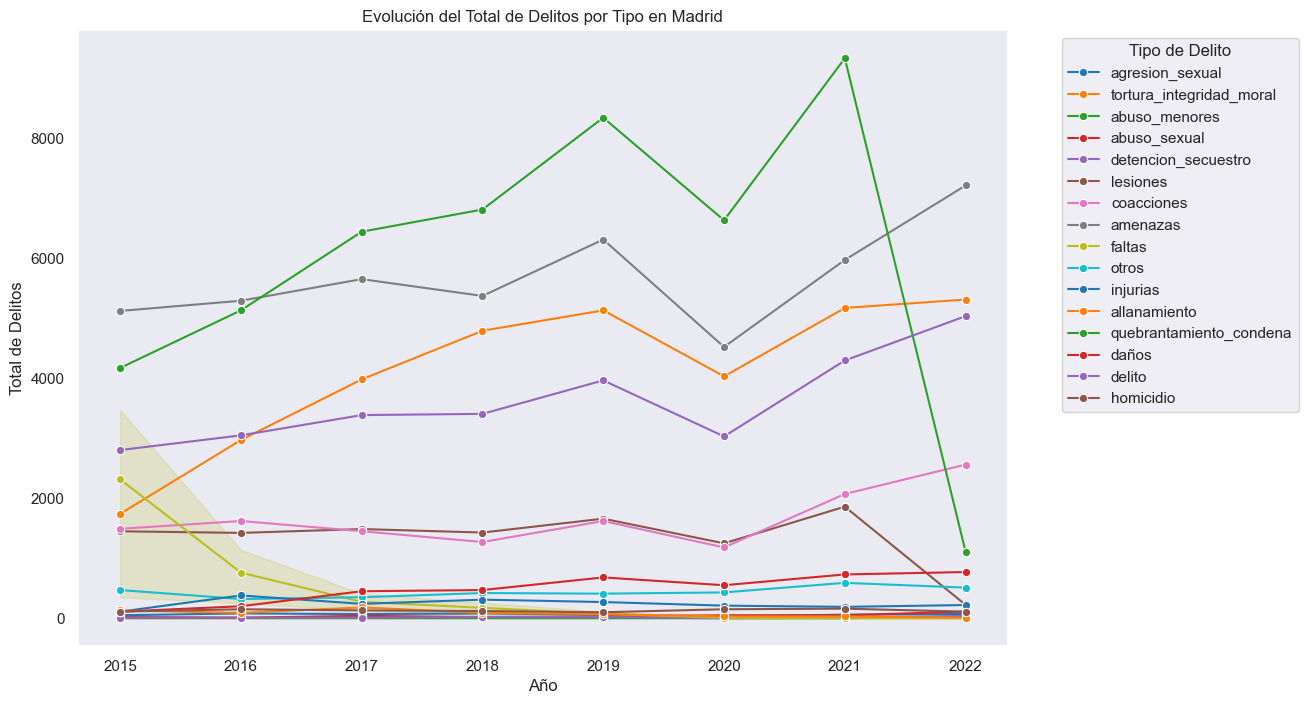

In [44]:
plot_delitos(tipos, 'madrid')

In [43]:
tipos.groupby('tipo')['total'].sum()

tipo
abuso_menores                  190
abuso_sexual                  3010
agresion_sexual               5220
allanamiento                  7280
amenazas                    401026
coacciones                  138610
daños                        47020
delito                      505360
detencion_secuestro           1840
faltas                      112540
homicidio                     6080
injurias                     33270
lesiones                    522843
otros                        39340
quebrantamiento_condena     378702
tortura_integridad_moral    367985
Name: total, dtype: int64